Introduction and Motivation
For our ENSF 612 project, we trained various models to predict the total ride duration of taxi trips in New York City (NYC). We chose to study this dataset because it offered insights into traffic patterns in one of the world's fastest-moving cities.

Our dataset was sourced from Kaggle. The dataset was cleaned specifically for a competition, enabling our group to concentrate on exploratory data analysis (EDA) and model building.

In this notebook, we train a `GBT` model on the cleaned dataset.

### Setup drive

In [ ]:
# connect to collab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# record time
import time

# start record
start = time.time()

Mounted at /content/drive


In [ ]:
# root directories
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/ENSF 612/project"

MEDIA_PATH = BASE_PATH  + "/media"
DATASET_PATH = BASE_PATH + "/dataset"

In [ ]:
# NYC dataset
TRAIN_DATASET = DATASET_PATH + "/" + "train_cleaned_clustered.csv"

### Library imports

In [ ]:
# normal imports
import os
import requests
from IPython.display import Image

# for dataframes
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# geodesic
from geopy.distance import geodesic

# calculation
from math import radians, cos, sin, asin, sqrt

from graphviz import Digraph

### Setup Spark

In [ ]:
# Install Java Development Kit (required for Apache Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark (version 3.5.0) with Hadoop (version 3)
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xf spark-3.5.0-bin-hadoop3.tgz

# Install the findspark library (used to locate and initialize Apache Spark)
!pip install -q findspark

# Set up the required environment variables for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize findspark and import SparkSession
import findspark
findspark.init()

In [ ]:
# eda
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, dayofweek, hour, count, when, year, month, minute, quarter, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql import types as T

# machine learning
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LinearRegressionModel, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [ ]:
# Create a Spark session and context
spark = SparkSession.builder.master("local").appName("Colab").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

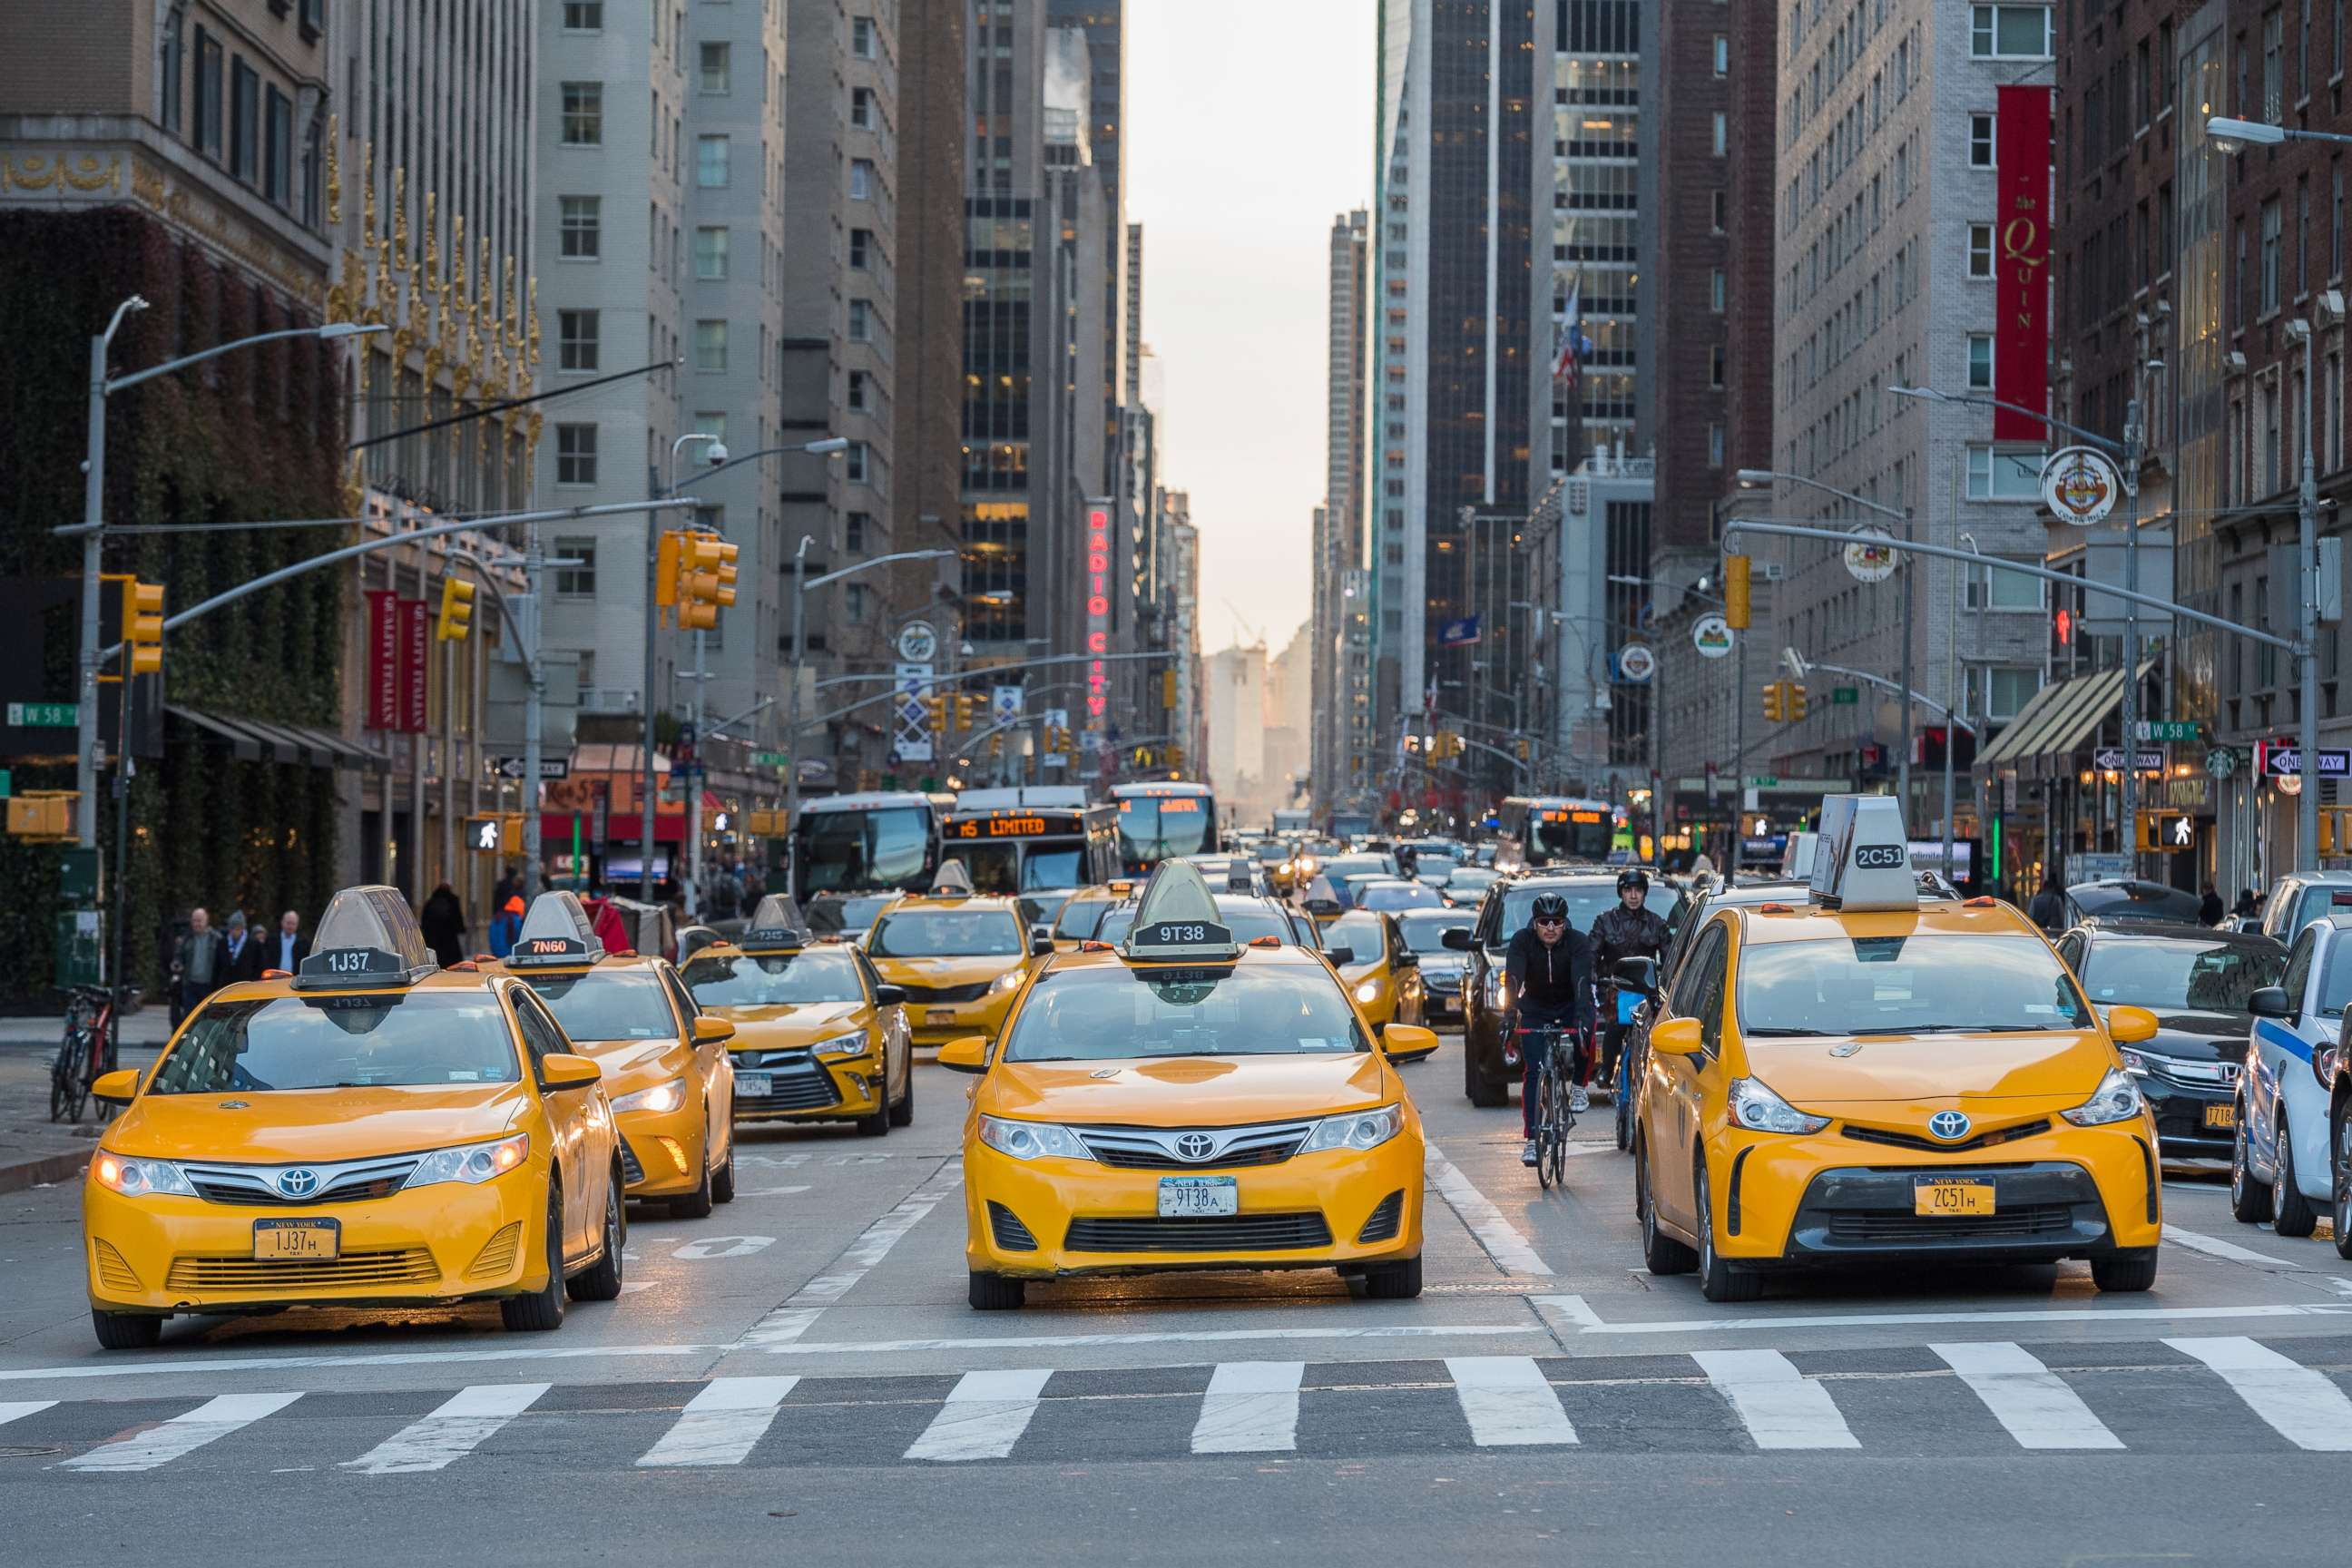

In [ ]:
nyc_image = MEDIA_PATH + "/nyc_image.jpg"
display(Image(filename=nyc_image))

### Read CSV

In [ ]:
spark = SparkSession.builder.appName("GBM").getOrCreate()

# Define the schema corresponding to the CSV file format
schema = StructType([
    StructField("trip_duration", FloatType(), True),
    StructField("distance", FloatType(), True),
    StructField("year", IntegerType(), True),
    StructField("quarter_of_year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("hour", IntegerType(), True),
    StructField("minute", IntegerType(), True),
    StructField("Sunday", IntegerType(), True),
    StructField("Monday", IntegerType(), True),
    StructField("Tuesday", IntegerType(), True),
    StructField("Wednesday", IntegerType(), True),
    StructField("Thursday", IntegerType(), True),
    StructField("Friday", IntegerType(), True),
    StructField("Saturday", IntegerType(), True),
    StructField("pickup_neighbourhood", IntegerType(), True),
    StructField("dropoff_neighbourhood", IntegerType(), True),
])

# Read the CSV file into a DataFrame
taxi_df = spark.read.csv(TRAIN_DATASET, schema=schema, header=True)
taxi_df.count()

961378

In [ ]:
# deep copy
taxi_df_final = taxi_df.select([col for col in taxi_df])

In [ ]:
taxi_df_final.show(5)

+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|pickup_neighbourhood|dropoff_neighbourhood|
+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|                  92|                  335|
|       2124.0|6.3850985|2016|              1|    1|  11|    35|     0|     0|      1|        0|       0|     0|       0|                 441|                  111|
|       1551.0|5.7149806|2016|              2|    5|   7|    54|     0|     0|      0|        0|       0|     0|       1|                  80|                  152|
|       12

In [ ]:
# split dataset
train_data, test_data = taxi_df_final.randomSplit([0.7, 0.3])

feature_columns = [col for col in taxi_df_final.columns if col != "trip_duration"]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")

### Gradient Boosting (baseline)

Here, we built the initial `GBT` model with the cleaned dataset.

In [ ]:
# GBT model
gbt = GBTRegressor(featuresCol="features_vec", labelCol="trip_duration", maxIter=10)

In [ ]:
# create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

In [ ]:
# fit the pipeline on the training data
pipeline_model = pipeline.fit(train_data)

In [ ]:
# evaluate the model on the test data
predictions = pipeline_model.transform(test_data)

In [ ]:
evaluatorRMSE = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
evaluatorR2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
rmse = evaluatorRMSE.evaluate(predictions)
r2 = evaluatorR2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("R2 on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 401.4850853177629
R2 on test data = 0.6533236163801319


### Gradient Boosting (pipeline)
We implemented a pipeline for hyper parameter tuning.

In [ ]:
# copy again to make sure its clean
taxi_df_final = taxi_df.select([col for col in taxi_df])

In [ ]:
# split the data into training and test sets
train_data, test_data = taxi_df_final.randomSplit([0.8, 0.2])

# create feature vectors using Assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")

# initialize StandardScaler
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")

In [ ]:
# initialize DecisionTreeRegressor model
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="trip_duration")

# create a pipeline with all the stages
pipeline = Pipeline(stages=[assembler, scaler, gbt])

# build the parameter grid for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [32, 40, 50]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")

# Cross-validator
cross_val = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [ ]:
# fit the model
cvModel = cross_val.fit(train_data)

In [ ]:
# fetch best model
bestModel = cvModel.bestModel

# evaluate the best model
predictions = bestModel.transform(test_data)
r2 = evaluator.evaluate(predictions)
evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)

print(f"Best Model Parameters: {bestModel.stages[-1].extractParamMap()}")
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

Best Model Parameters: {Param(parent='GBTRegressor_3d9619fd54f2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_3d9619fd54f2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_3d9619fd54f2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and t

### Visualization

After hyper parameter tuning and model evaluation, we plotted the results.

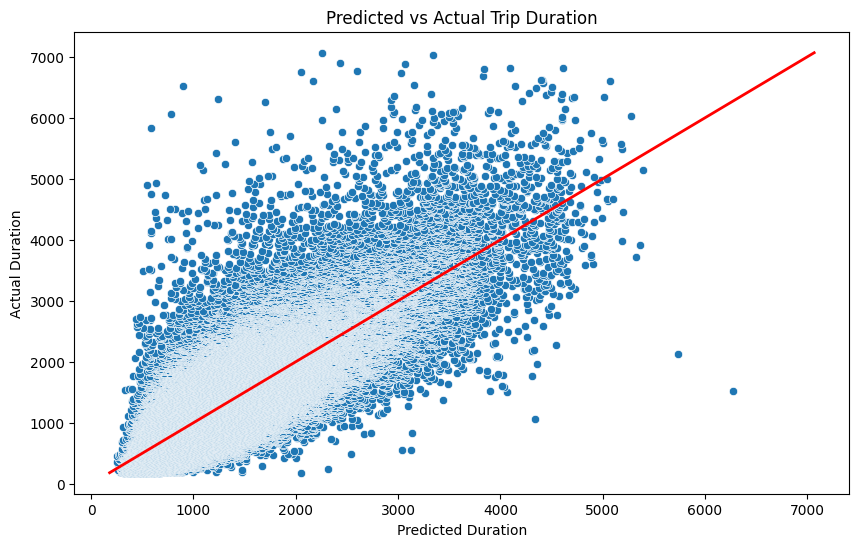

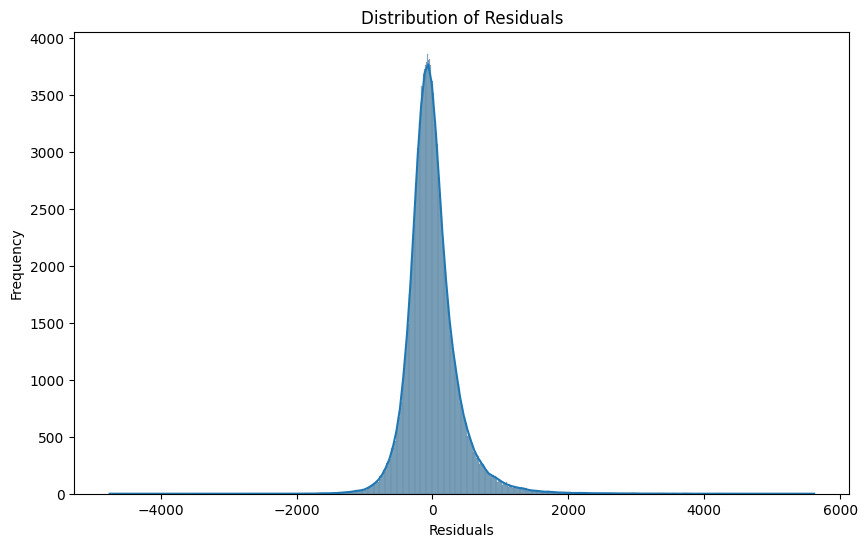

In [ ]:
# convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("prediction", "trip_duration").toPandas()

# plotting Prediction vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="trip_duration", data=predictions_pd)
plt.plot([predictions_pd["trip_duration"].min(), predictions_pd["trip_duration"].max()],
         [predictions_pd["trip_duration"].min(), predictions_pd["trip_duration"].max()],
         color="red", lw=2)
plt.xlabel("Predicted Duration")
plt.ylabel("Actual Duration")
plt.title("Predicted vs Actual Trip Duration")
plt.show()

# plotting Residuals
predictions_pd["residuals"] = predictions_pd["trip_duration"] - predictions_pd["prediction"]
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pd["residuals"], kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

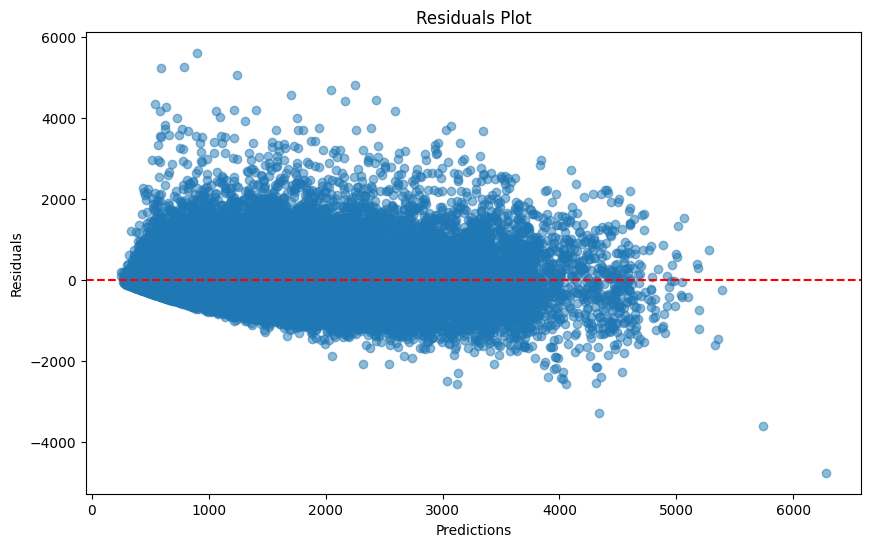

In [ ]:
# calculate residuals
predictions_pd["residuals"] = predictions_pd["trip_duration"] - predictions_pd["prediction"]

# residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["prediction"], predictions_pd["residuals"], alpha=0.5)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color="r", linestyle="--")

<ipython-input-26-c18101351245>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions_pd["trip_duration"], label="True Values", shade=True)
<ipython-input-26-c18101351245>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions_pd["prediction"], label="Predicted Values", shade=True)


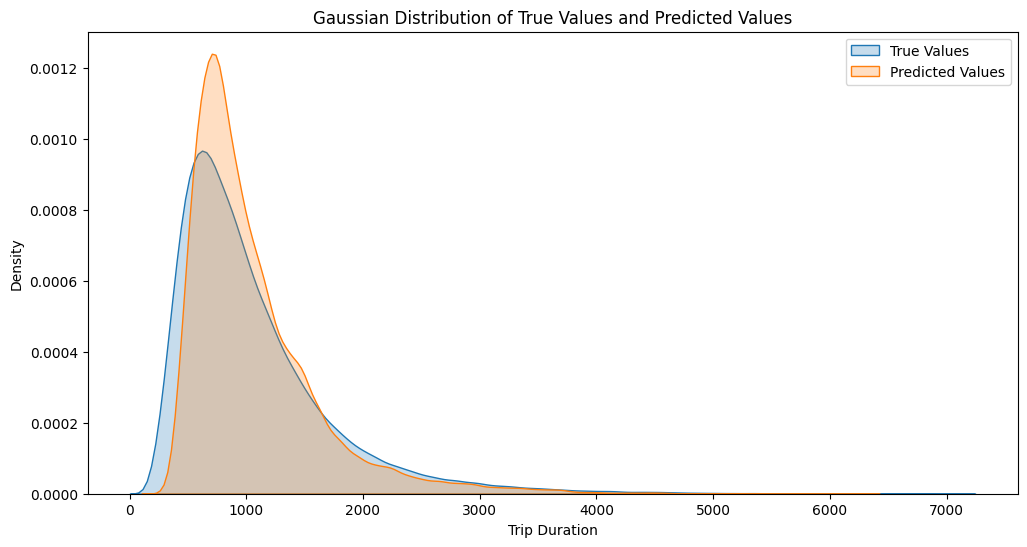

In [ ]:
plt.figure(figsize=(12, 6))

# KDE plot for True Values
sns.kdeplot(predictions_pd["trip_duration"], label="True Values", shade=True)

# KDE plot for Predicted Values
sns.kdeplot(predictions_pd["prediction"], label="Predicted Values", shade=True)

plt.title("Gaussian Distribution of True Values and Predicted Values")
plt.xlabel("Trip Duration")
plt.ylabel("Density")
plt.legend()

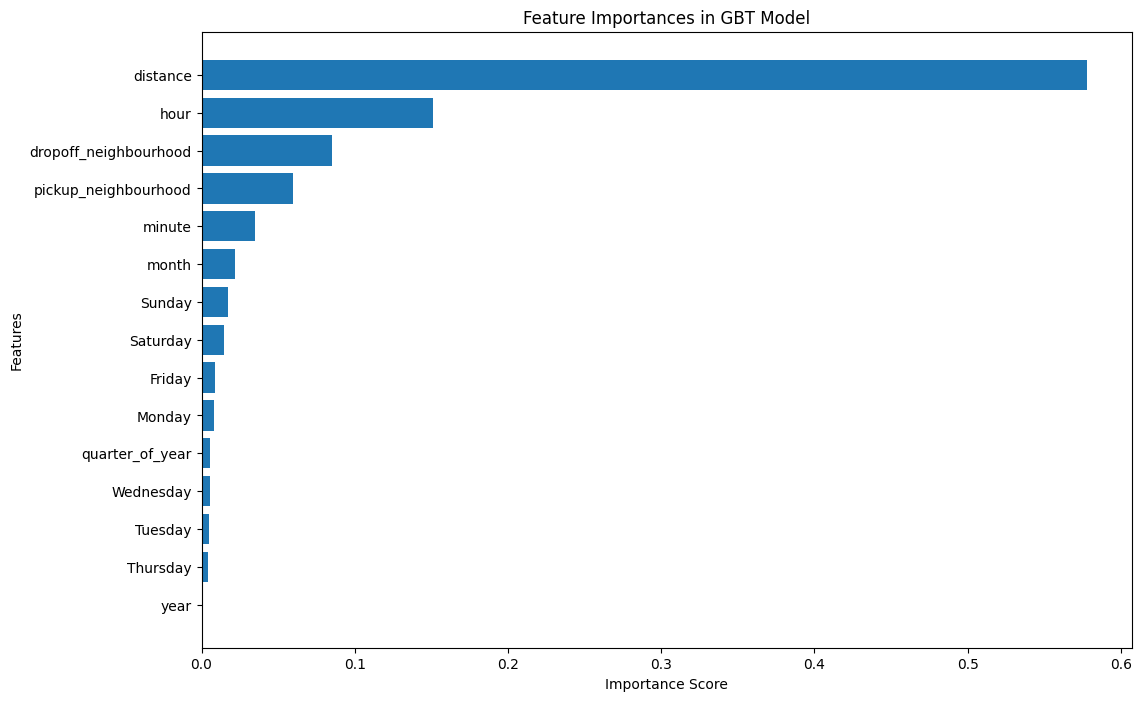

In [ ]:
gbtModel = bestModel.stages[-1]
importances = gbtModel.featureImportances

feature_importance_list = [(feature, importance) for feature, importance in zip(feature_columns, importances)]
feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# unzipping the feature names and their importances
features, importances = zip(*feature_importance_list)

plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances, align="center")
plt.yticks(range(len(importances)), features)
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importances in GBT Model")

### End of notebook

In [ ]:
end = time.time()
delta_time = end - start
print(F"It took {delta_time} s to run the notebook.")

It took 13667.772471666336 s to run the notebook.
